<a href="https://colab.research.google.com/github/babaroscopy/colab/blob/main/Ensembling_cr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Rohit-Kundu/Ensemble-Pneumonia-Detection.git

Cloning into 'Ensemble-Pneumonia-Detection'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 85 (delta 50), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (85/85), done.


In [2]:
!mkdir Ensemble-Pneumonia-Detection/train_csv
!mkdir Ensemble-Pneumonia-Detection/test_csv
#f = open("Ensemble-Pneumonia-Detection/train_csv/resnet18_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/resnet18_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/googlenet_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/googlenet_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/densenet121_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/densenet121_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/inception_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/inception_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/alex_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/alex_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_csv/vgg_train.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_csv/vgg_test.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/train_labels.csv", "x")
#f = open("Ensemble-Pneumonia-Detection/test_labels.csv", "x")

In [3]:
pip install scikit-plot

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import *
import math
import scikitplot as skplt

In [5]:
def getfile(filename):
    root="./"
    file = root+filename
    if '.csv' not in file:
        file+='.csv'
    df = pd.read_csv(file,header=None)
    df = np.asarray(df)[:,:-1] #Since last column has image names
    return df

In [6]:
def getlabels(filename):
    root="./"
    file = root+filename
    if '.csv' not in file:
        file+='.csv'
    df = pd.read_csv(file,header=None)
    df = np.asarray(df)[:,1] #Since first column has image names
    return df.astype(int)

In [7]:
def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

In [8]:
def metrics(labels,predictions,classes):
    print("Classification Report:")
    print(classification_report(labels, predictions, target_names = classes,digits = 4))
    skplt.metrics.plot_confusion_matrix(labels, predictions, normalize=True)
    matrix = confusion_matrix(labels, predictions,normalize='all')
    '''
    print("Confusion matrix:")
    print(matrix)'''
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))

In [9]:

def get_scores(labels, *argv):
    #outputs matrix of shape (no. of arg, 4) of precision, recall, f1-score, Area Under Curve
    count = len(argv)
    metrics = np.zeros(shape=(4,count))
    num_classes = np.unique(labels).shape[0]
    for i, arg in enumerate(argv):
        preds = predicting(arg)
        if num_classes==2:
            pre = precision_score(labels,preds[:640])
            rec = recall_score(labels,preds[:640])
            f1 = f1_score(labels,preds[:640])
            auc = roc_auc_score(labels,preds[:640])
        else:
            pre = precision_score(labels,preds[:640],average='macro')
            rec = recall_score(labels,preds[:640],average='macro')
            f1 = f1_score(labels,preds[:640],average='macro')
            auc = roc_auc_score(labels,arg[:640],average='macro',multi_class='ovo')
        metrics[:,i] = np.array([pre,rec,f1,auc])
    weights = get_weights(np.transpose(metrics))
    #print("Weights: ",weights)
    return weights
    '''

def get_scores(labels,*argv):
    #outputs matrix of shape (no. of arg, 4) of precision, recall, f1-score, Area Under Curve
    count = len(argv)
    metrics = np.zeros(shape=(4,count))
    num_classes = np.unique(labels).shape[0]
    for i,arg in enumerate(argv):
        preds = predicting(arg)
        print(labels.shape)
        print(preds.shape)
        print(len(labels))
        print(len(preds))
        if num_classes==2:
            pre = precision_score(labels,preds)
            rec = recall_score(labels,preds)
            f1 = f1_score(labels,preds)
            auc = roc_auc_score(labels,preds)
        else:
            pre = precision_score(labels,preds,average='macro')
            rec = recall_score(labels,preds,average='macro')
            f1 = f1_score(labels,preds,average='macro')
            auc = roc_auc_score(labels,arg,average='macro',multi_class='ovo')
        metrics[:,i] = np.array([pre,rec,f1,auc])
    weights = get_weights(np.transpose(metrics))
    #print("Weights: ",weights)
    return weights
'''

In [10]:
def get_weights(matrix):
    weights = []
    for i in range(matrix.shape[0]):
        m = matrix[i]
        w = 0
        for j in range(m.shape[0]):
            w+=np.tanh(m[j])
        weights.append(w)
    return weights

In [11]:
root_train = "Ensemble-Pneumonia-Detection/train_csv/"
root_test  = "Ensemble-Pneumonia-Detection/test_csv/"
'''
train_labels = "Ensemble-Pneumonia-Detection/train_labels.csv"
train_labels = getlabels(train_labels)

test_labels = "Ensemble-Pneumonia-Detection/test_labels.csv"
test_labels = getlabels(test_labels)
'''

'\ntrain_labels = "Ensemble-Pneumonia-Detection/train_labels.csv"\ntrain_labels = getlabels(train_labels)\n\ntest_labels = "Ensemble-Pneumonia-Detection/test_labels.csv"\ntest_labels = getlabels(test_labels)\n'

In [12]:
csv_list = os.listdir(root_train)
p1_train = getfile(root_train+csv_list[0])
p2_train = getfile(root_train+csv_list[1])
p3_train = getfile(root_train+csv_list[2])
p4_train = getfile(root_train+csv_list[3])
p5_train = getfile(root_train+csv_list[4])
p6_train = getfile(root_train+csv_list[5])

train_labels = "Ensemble-Pneumonia-Detection/train_labels.csv"
train_labels = getlabels(train_labels)
#train_labels = getlabels(train_labels)

p1_test = getfile(root_test+csv_list[0].replace('train','test'))
p2_test = getfile(root_test+csv_list[1].replace('train','test'))
p3_test = getfile(root_test+csv_list[2].replace('train','test'))
p4_test = getfile(root_test+csv_list[3].replace('train','test'))
p5_test = getfile(root_test+csv_list[4].replace('train','test'))
p6_test = getfile(root_test+csv_list[5].replace('train','test'))

test_labels = "Ensemble-Pneumonia-Detection/test_labels.csv"
test_labels = getlabels(test_labels)
#test_labels = getlabels(test_labels)

In [13]:
weights = get_scores(train_labels, p1_train, p2_train,p3_train, p4_train,p5_train, p6_train)

ensemble_prob = weights[0]*p1_test+weights[1]*p2_test+weights[2]*p3_test+weights[3]*p4_test+weights[4]*p5_test+weights[5]*p6_test
preds = predicting(ensemble_prob)
correct = np.where(preds == test_labels)[0].shape[0]
total = test_labels.shape[0]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

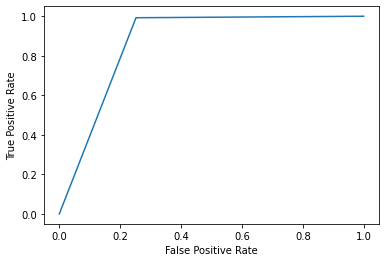

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test_labels,preds)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

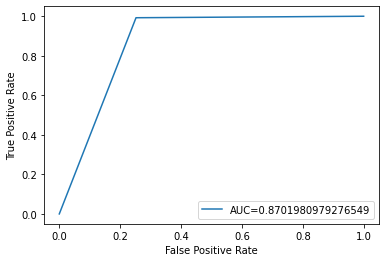

In [ ]:
auc = metrics.roc_auc_score(test_labels,preds)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy =  0.9
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9837    0.7479    0.8498       242
   Pneumonia     0.8662    0.9925    0.9251       398

    accuracy                         0.9000       640
   macro avg     0.9250    0.8702    0.8874       640
weighted avg     0.9106    0.9000    0.8966       640


Classwise Accuracy :[0.74793388 0.99246231]


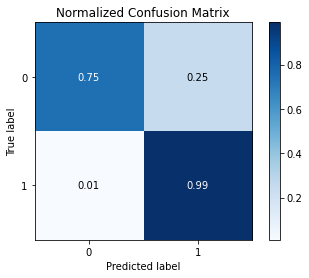

In [ ]:
print("Accuracy = ",correct/total)
classes = ['Normal','Pneumonia']
metrics(test_labels,preds,classes)